# 필요 라이브러리 import

In [ ]:
import os
import urllib.request
import zipfile
import tarfile
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import random
import time
from copy import deepcopy
import seaborn as sns
import torch.optim as optim
import argparse

# 시드 고정

In [ ]:
def seed(SEED=123):
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = False
SEED=123
seed(SEED=SEED)

# 데이터 다운로드

In [ ]:
def download_and_extract(url, dest_dir):
    zip_path = os.path.join(dest_dir, "caltech-101.zip")

    # 디렉토리 생성
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)

    # 데이터 다운로드
    if not os.path.exists(zip_path):
        print("Downloading dataset...")
        urllib.request.urlretrieve(url, zip_path)
        print("Download complete.")

    # ZIP 파일 압축 해제
    print("Extracting ZIP dataset...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(dest_dir)
    print("ZIP extraction complete.")

    # ZIP 내부의 tar.gz 파일 찾기
    extracted_folder = os.path.join(dest_dir, "caltech-101")
    tar_path = os.path.join(extracted_folder, "101_ObjectCategories.tar.gz")

    # TAR.GZ 파일 압축 해제
    if os.path.exists(tar_path):
        print("Extracting TAR.GZ dataset...")
        with tarfile.open(tar_path, 'r:gz') as tar_ref:
            tar_ref.extractall(extracted_folder)
        print("TAR.GZ extraction complete.")

In [ ]:
# 데이터 다운로드 및 압축 해제
DATA_URL = "https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip?download=1"
DATA_DIR = "./caltech101"

download_and_extract(DATA_URL, DATA_DIR)

Download complete.
Extracting ZIP dataset...
ZIP extraction complete.
Extracting TAR.GZ dataset...
TAR.GZ extraction complete.


# 커스텀 데이터셋 작성

In [ ]:
class Caltech101Dataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d)) and d != "BACKGROUND_Google"]) # BACKGROUND_Google을 제외한 101가지(Label:0~100) 범주로 만듬
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)} # Label값과 클래스 이름을 대응시킴

        self.image_paths = []
        self.labels = {}

        for label, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            if os.path.isdir(class_dir):
                for img_name in os.listdir(class_dir):
                    if img_name.endswith(('.jpg', '.jpeg', '.png')):
                        img_path = os.path.join(class_dir, img_name)
                        self.image_paths.append(img_path)
                        self.labels[img_path] = label  # 파일 경로를 키로 하여 라벨 저장

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[img_path]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
# 데이터 변환 정의
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(180), # 랜덤으로 좌우 180도 회전하는 변형
    transforms.RandomAffine(degrees=0, scale=(0.8, 1.2), shear=20), # 랜덤으로 크기를 0.8~1.2배로 만들고 좌우 20도 기울이는 변형
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]) # 이미지넷의 z-score를 이용
    ])

img_dir = os.path.join(DATA_DIR, "caltech-101/101_ObjectCategories")
dataset = Caltech101Dataset(root_dir=img_dir,
                            transform=transform)

# 데이터 개수 정의
train_num = int(len(dataset)*0.6) # 60%의 학습 데이터셋
val_num = int((len(dataset) - train_num)*0.5) # 20%의 검증 데이터셋
test_num = len(dataset) - train_num - val_num # 20%의 테스트 데이터셋

# 데이터 나누기
train_dataset, validation_dataset, test_dataset = random_split(dataset, [train_num, val_num, test_num])
partition = {'train': train_dataset, 'val':validation_dataset, 'test':test_dataset}

# 커스텀 데이터셋 시각화

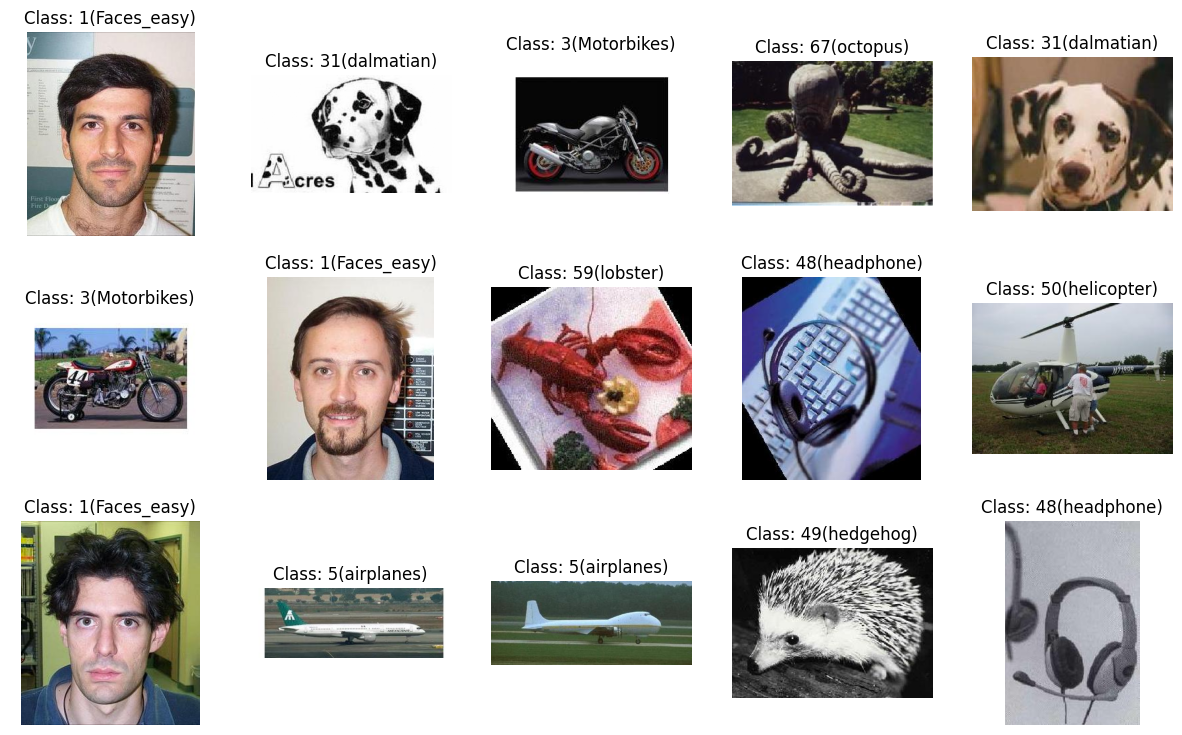

In [ ]:
img_dir = os.path.join(DATA_DIR, "caltech-101/101_ObjectCategories")
data = Caltech101Dataset(root_dir=img_dir,
                        transform=transforms.ToTensor()) # 시각화 시엔 기본 이미지를 사용하였다.

random_indices = random.sample(range(len(data)), 15)
samples = [data[idx] for idx in random_indices]

idx_to_class = {v: k for k, v in data.class_to_idx.items()}

fig, axes = plt.subplots(3, 5, figsize=(15, 9))

for i, (image, label) in enumerate(samples):
    row, col = divmod(i, 5)
    axes[row, col].imshow(image.permute(1, 2, 0))
    axes[row, col].set_title(f"Class: {label}({idx_to_class[label]})")
    axes[row, col].axis("off")


plt.show()

# Resnet 모델 구성

In [ ]:
# ResNet, SeNet의 기본 구성인 Conv3X3, Conv1X1 블록 정의
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    return nn.Conv2d(in_planes, out_planes,
                     kernel_size=3, stride=stride,
                     padding=dilation, groups=groups,
                     bias=False, dilation=dilation)

def conv1x1(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes,
                     kernel_size=1, stride=stride,
                     bias=False)

In [ ]:
# ResNet18, 34에 쓰이는 BasicBlock 정의, Conv3X3만 이용하는 특징이 있다.
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, out_planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(in_planes, out_planes, stride)
        self.bn1 = nn.BatchNorm2d(out_planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_planes, out_planes)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out

In [ ]:
# ResNet50, 101, 152에 쓰이는 BottleneckBlock 정의, Conv3X3뿐만 아니라 Conv1X1도 사용한다는 특징이 있다.
class BottleneckBlock(nn.Module):
    expansion = 4

    def __init__(self, in_planes, out_planes, stride=1, downsample=None):
        super(BottleneckBlock, self).__init__()
        self.conv1 = conv1x1(in_planes, out_planes)
        self.bn1 = nn.BatchNorm2d(out_planes)
        self.conv2 = conv3x3(out_planes, out_planes, stride)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.conv3 = conv1x1(out_planes, out_planes * 4)
        self.bn3 = nn.BatchNorm2d(out_planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)

        out += identity
        out = self.relu(out)

        return out

In [ ]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=101):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        self._initialize_weights()

    def _make_layer(self, block, out_planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_planes != out_planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.in_planes, out_planes * block.expansion, stride),
                nn.BatchNorm2d(out_planes * block.expansion),
            )

        layers = [block(self.in_planes, out_planes, stride, downsample)]
        self.in_planes = out_planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_planes, out_planes))

        return nn.Sequential(*layers)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


In [ ]:
# 편하게 사용하기 위하여 존재하는 ResNet모델들을 정의함
def resnet18(num_classes=101):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)

def resnet34(num_classes=101):
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes)

def resnet50(num_classes=101):
    return ResNet(BottleneckBlock, [3, 4, 6, 3], num_classes)

def resnet101(num_classes=101):
    return ResNet(BottleneckBlock, [3, 4, 23, 3], num_classes)

def resnet152(num_classes=101):
    return ResNet(BottleneckBlock, [3, 8, 36, 3], num_classes)

# SeNet 모델 구성

In [ ]:
# 중요도에 따라 채널의 가중치를 정하는 SELayer 정의, ResNet과의 주요 차이점이다.
class SELayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)


In [ ]:
# 기존 ResNet의 BasicBlock을 지난 후 잔차를 더하기 전에 SELayer를 적용한다는 점이 특징이다.
class SEBasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, out_planes, stride=1, downsample=None, reduction=16):
        super(SEBasicBlock, self).__init__()
        self.conv1 = conv3x3(in_planes, out_planes, stride)
        self.bn1 = nn.BatchNorm2d(out_planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_planes, out_planes)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.se = SELayer(out_planes, reduction)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.se(out)

        out += identity
        out = self.relu(out)

        return out

In [ ]:
# 기존 ResNet의 BottleneckBlock을 지난 후 잔차를 더하기 전에 SELayer를 적용한다는 점이 특징이다.
class SEBottleneckBlock(nn.Module):
    expansion = 4

    def __init__(self, in_planes, out_planes, stride=1, downsample=None, reduction=16):
        super(SEBottleneckBlock, self).__init__()
        self.conv1 = conv1x1(in_planes, out_planes)
        self.bn1 = nn.BatchNorm2d(out_planes)
        self.conv2 = conv3x3(out_planes, out_planes, stride)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.conv3 = conv1x1(out_planes, out_planes * 4)
        self.bn3 = nn.BatchNorm2d(out_planes * 4)
        self.se = SELayer(out_planes * 4, reduction)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        out = self.se(out)

        out += identity
        out = self.relu(out)

        return out

In [ ]:
class SENet(nn.Module):
    def __init__(self, block, layers, num_classes=101, reduction=16):
        super(SENet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0], reduction)
        self.layer2 = self._make_layer(block, 128, layers[1], reduction, stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], reduction, stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], reduction, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_planes, blocks, reduction, stride=1):
        downsample = None
        if stride != 1 or self.in_planes != out_planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.in_planes, out_planes * block.expansion, stride),
                nn.BatchNorm2d(out_planes * block.expansion),
            )

        layers = [block(self.in_planes, out_planes, stride, downsample, reduction)]
        self.in_planes = out_planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_planes, out_planes, reduction=reduction))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [ ]:
# 편하게 사용하기 위하여 존재하는 SeNet모델들을 정의함
def senet18(num_classes=101):
    return SENet(SEBasicBlock, [2, 2, 2, 2], num_classes)

def senet34(num_classes=101):
    return SENet(SEBasicBlock, [3, 4, 6, 3], num_classes)

def senet50(num_classes=101):
    return SENet(SEBottleneckBlock, [3, 4, 6, 3], num_classes)

def senet101(num_classes=101):
    return SENet(SEBottleneckBlock, [3, 4, 23, 3], num_classes)

def senet152(num_classes=101):
    return SENet(SEBottleneckBlock, [3, 8, 36, 3], num_classes)

# Train, Validation, Test, Experiment 정의

In [ ]:
def train(net, partition, optimizer, criterion, args):
    trainloader = torch.utils.data.DataLoader(partition['train'],
                                              batch_size=args.train_batch_size,
                                              shuffle=True, num_workers=8)
    net.train()

    scaler = torch.cuda.amp.GradScaler() # AMP사용을 위한 scaler정의

    correct = 0
    total = 0
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        optimizer.zero_grad()

        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        with torch.cuda.amp.autocast(): # 자동으로 FP16, FP32로 캐스팅하여 Loss계산과 가중치 업데이트는 FP32로, 행렬곱 연산(Feedforward, Backpropagation)은 FP16으로 진행하여 연산을 빠르게 진행한다는 점이 특징이다.
            outputs = net(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward() # backward, gradient계산, 가중치 업데이트까지 사용된다.
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = train_loss / len(trainloader)
    train_acc = 100 * correct / total
    return net, train_loss, train_acc

In [ ]:
def validate(net, partition, criterion, args):
    valloader = torch.utils.data.DataLoader(partition['val'],
                                            batch_size=args.test_batch_size,
                                            shuffle=False, num_workers=8)
    net.eval()

    correct = 0
    total = 0
    val_loss = 0
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            outputs = net(images)

            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(valloader)
        val_acc = 100 * correct / total
    return val_loss, val_acc

In [ ]:
def test(net, partition, args):
    testloader = torch.utils.data.DataLoader(partition['test'],
                                             batch_size=args.test_batch_size,
                                             shuffle=False, num_workers=8)
    net.eval()

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
    return test_acc

In [ ]:
def experiment(net, partition, args):

    net.cuda()

    criterion = nn.CrossEntropyLoss()
    if args.optim == 'SGD':
        optimizer = optim.SGD(net.parameters(), lr=args.lr, weight_decay=args.l2, momentum=0.9)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice')

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(args.epoch):
        ts = time.time()
        net, train_loss, train_acc = train(net, partition, optimizer, criterion, args)
        val_loss, val_acc = validate(net, partition, criterion, args)
        te = time.time()

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.2f}/{:2.2f}. Took {:2.2f} sec'.format(epoch, train_acc, val_acc, train_loss, val_loss, te-ts))

    test_acc = test(net, partition, args)

    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    result['test_acc'] = test_acc
    return result

# 시각화 정의

In [ ]:
def plot_accuracy(result):

    epochs = list(range(len(result['train_accs'])))
    test_acc = result['test_acc']

    sns.set_style("darkgrid")

    plt.figure(figsize=(10, 6))
    sns.lineplot(x=epochs, y=result['train_accs'], label='Train Accuracy', marker='o')
    sns.lineplot(x=epochs, y=result['val_accs'], label='Validation Accuracy', marker='s')

    plt.text(0.05, 0.95, f"Test Accuracy: {test_acc:.2f}%",
             horizontalalignment='left', verticalalignment='center',
             transform=plt.gca().transAxes,
             bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.3"))

    plt.title('Accuracy by Epoch', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy (%)', fontsize=12)
    plt.legend()

    plt.show()

# 인자 설정 및 실험

In [ ]:
parser = argparse.ArgumentParser()
args = parser.parse_args("")

args.optim = 'Adam'
args.lr = 0.0001
args.epoch = 50
args.l2 = 0.00001

args.train_batch_size = 64
args.test_batch_size = 128

<ipython-input-19-9ec64b8af669>:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
<ipython-input-19-9ec64b8af669>:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 0, Acc(train/val): 17.48/23.34, Loss(train/val) 4.06/3.84. Took 11.10 sec
Epoch 1, Acc(train/val): 24.84/20.29, Loss(train/val) 3.63/3.87. Took 8.52 sec
Epoch 2, Acc(train/val): 28.39/25.01, Loss(train/val) 3.36/3.46. Took 8.62 sec
Epoch 3, Acc(train/val): 30.43/32.51, Loss(train/val) 3.19/3.16. Took 8.55 sec
Epoch 4, Acc(train/val): 32.56/35.04, Loss(train/val) 3.05/3.02. Took 8.66 sec
Epoch 5, Acc(train/val): 34.59/35.10, Loss(train/val) 2.92/2.95. Took 8.88 sec
Epoch 6, Acc(train/val): 36.17/38.04, Loss(train/val) 2.78/2.84. Took 8.62 sec
Epoch 7, Acc(train/val): 38.17/35.91, Loss(train/val) 2.69/2.80. Took 8.51 sec
Epoch 8, Acc(train/val): 39.36/38.73, Loss(train/val) 2.59/2.79. Took 8.64 sec
Epoch 9, Acc(train/val): 40.86/42.42, Loss(train/val) 2.49/2.63. Took 8.54 sec
Epoch 10, Acc(train/val): 42.11/37.81, Loss(train/val) 2.43/2.70. Took 8.62 sec
Epoch 11, Acc(train/val): 43.76/41.56, Loss(train/val) 2.34/2.63. Took 8.75 sec
Epoch 12, Acc(train/val): 44.72/43.52, Loss(train

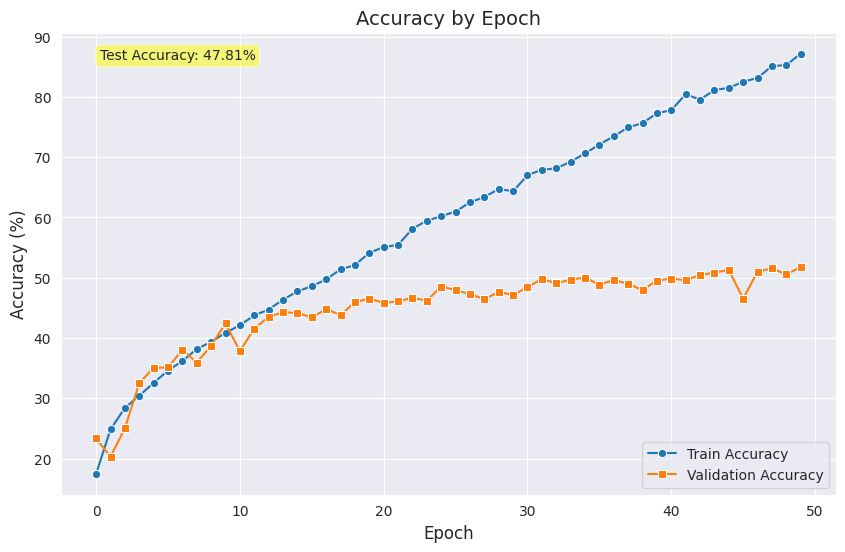

In [ ]:
# ResNet50 학습 및 결과 시각화
result = experiment(resnet50(), partition, deepcopy(args))
plot_accuracy(result)

<ipython-input-19-9ec64b8af669>:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
<ipython-input-19-9ec64b8af669>:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 0, Acc(train/val): 24.15/26.97, Loss(train/val) 3.73/3.93. Took 9.89 sec
Epoch 1, Acc(train/val): 31.94/32.91, Loss(train/val) 3.13/3.06. Took 9.79 sec
Epoch 2, Acc(train/val): 35.88/35.68, Loss(train/val) 2.86/2.86. Took 9.81 sec
Epoch 3, Acc(train/val): 39.03/38.44, Loss(train/val) 2.66/2.71. Took 9.95 sec
Epoch 4, Acc(train/val): 41.59/39.71, Loss(train/val) 2.50/2.70. Took 10.09 sec
Epoch 5, Acc(train/val): 43.62/41.67, Loss(train/val) 2.38/2.59. Took 9.89 sec
Epoch 6, Acc(train/val): 45.35/42.48, Loss(train/val) 2.26/2.51. Took 9.78 sec
Epoch 7, Acc(train/val): 47.33/43.46, Loss(train/val) 2.17/2.47. Took 9.88 sec
Epoch 8, Acc(train/val): 49.71/45.99, Loss(train/val) 2.04/2.42. Took 9.69 sec
Epoch 9, Acc(train/val): 51.69/43.92, Loss(train/val) 1.92/2.59. Took 9.69 sec
Epoch 10, Acc(train/val): 52.80/46.46, Loss(train/val) 1.85/2.37. Took 10.24 sec
Epoch 11, Acc(train/val): 55.22/46.97, Loss(train/val) 1.75/2.32. Took 9.94 sec
Epoch 12, Acc(train/val): 56.61/48.30, Loss(trai

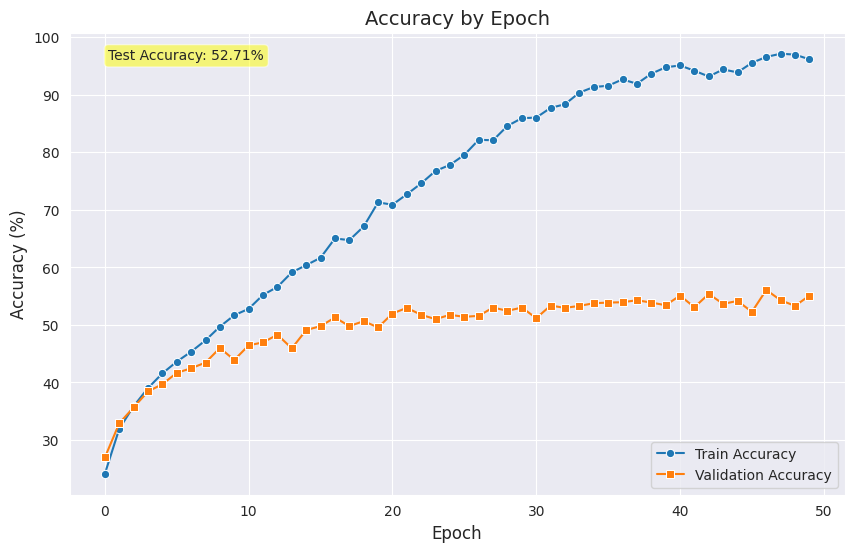

In [ ]:
# SeNet50 학습 및 결과 시각화
result = experiment(senet50(), partition, deepcopy(args))
plot_accuracy(result)

#보고서

## 1. 요약

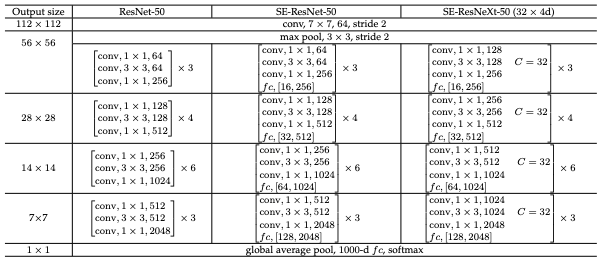

기존 ResNet모델에 채널 별 가중치를 적용하는 SELayer를 각 Block에 추가한 SeNet(SE-ResNet)모델을 구현하고 ResNet-50과 SeNet-50을 Caltech 101 Dataset에 대한 이미지 분류 문제를 학습시킨 결과 SeNet-50의 정확도가 ResNet-50보다 약 4.9%정도 높은 것으로 확인됐다.

## 2. Caltech 101 Dataset

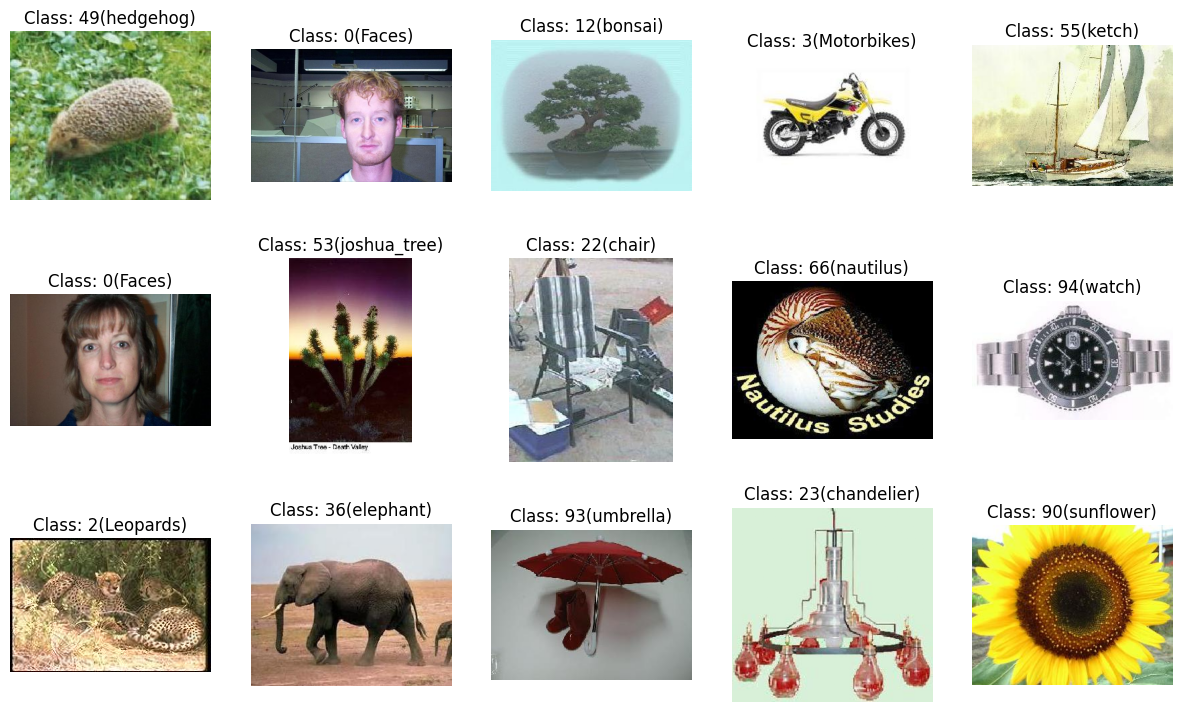

- 데이터셋 링크 : https://data.caltech.edu/records/mzrjq-6wc02

- 101 범주를 가졌고, 약 9000개의 이미지를 가진 중간 크기의 데이터셋

- 데이터 범주마다 이미지 개수는 40~800개로 데이터 불균형이 존재한다.

  - 보완 방법

    1. Class Weight : 클래스마다 손실함수 결과의 가중치를 다르게 준다.

    2. Under Sampling : 높은 비율을 차지하는 데이터의 수를 줄여 다른 데이터 수와 비슷하게 만든다.

    3. Over Sampling : 데이터 증강, 이미지 생성 등의 방법을 이용해 부족한 이미지 수를 늘려준다.

- 활용 분야
  
  1. 이미지 분류 : 범주별로 폴더가 나뉘어져있어 폴더 별로 라벨을 만들 수 있다.

  2. 이미지 세그멘테이션 : 일부 사진에 세그먼테이션 마스크 파일이 존재하므로 각 픽셀을 영역으로 구분 가능하다.

## 3. 실험 과정

- 커스텀 데이터셋 제작

  - 이미지를 직접 다운로드받아 커스텀데이터셋을 제작했다.

  - 101_ObjectCategories.gz 파일 내에 각 범주명 폴더가 있고 안에 범주에 맞는 사진이 존재하는 데이터셋이다.
  
  - 각 이미지 폴더명을 키로 이미지 범주를 분류하였다.

  - trainset, validationset, testset을 각 60:20:20 비율로 나누었다.

- 데이터 증강
  
  - 각 데이터의 사진 크기가 모두 달랐기 때문에 사진을 (224, 224)크기로 통일하였다.

  - RandomRotation, RandomAffine을 통해 사진의 회전에도 강건한 학습을 진행시키고자 했다.

  - Normalize를 통해 일관된 데이터 분포를 만들어 학습 속도와 일반화 성능을 향상시키고자 했다.

- AMP : pytorch의 torch.cuda.amp 패키지를 통해 학습 과정에서 GPU의 CudaCore를 사용하는 mixed-precision연산을 이용했고 1 epoch당 8, 9초대로 빠르게 학습할 수 있었다.

## 4. 실험 결과

ResNet-50의 학습결과 (정확도 47.81%)

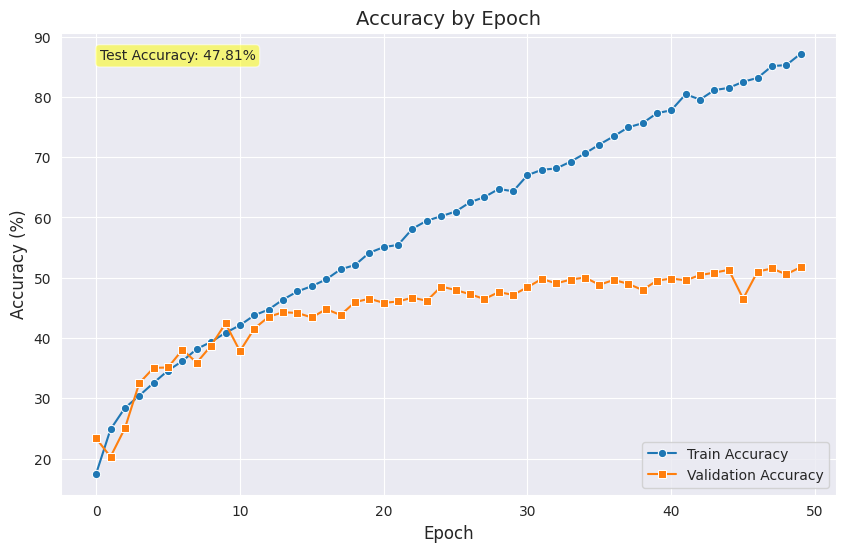

SeNet-50의 학습결과 (정확도 52.71%)

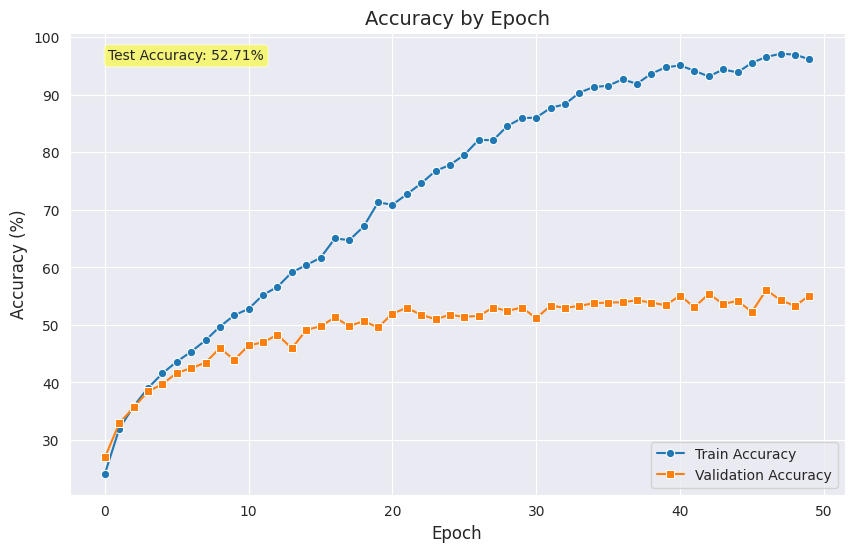

## 6. 실험 분석 및 고찰

- 결과 분석

  - 전체적으로 SeNet-50의 분류 성능이 ResNet-50의 성능보다 약 10% 정도 높고 학습이 다소 안정적으로 진행되는 것을 볼 수 있다.

  - 하지만 CNN과제와 마찬가지로 오버피팅 문제는 아직 존재한다.

- 결과 고찰

  - 오버피팅 문제의 첫 번째 이유로는 데이터 양에 비해 큰 모델을 사용해서 그렇다고 생각한다. 물론 IIIT Pet Dataset보다는 많은 양의 데이터이지만, 그때보다 큰 모델을 사용하였기 때문에 파라미터의 개수가 많아져 특징을 외우는 식으로 학습이 진행되어서 모델의 정확도가 50%대가 된 것 같다.

  - 오버피팅 문제의 두 번째 이유로는 데이터 불균형 때문이라고 생각한다. 각 범주의 사진이 최대 800개 최소 31개로 매우 차이가 많이 나기 때문에 데이터가 많은 클래스의 특징을 학습을 더 많이 했을 것이고 이 때문에 일반화 성능이 훈련 성능보다 낮았다고 생각한다.

  - 다음에 이러한 데이터셋으로 이미지 분류 문제를 해결할 경우엔 Class Weight, Over Sampling등의 방법을 이용해 데이터 수에 대한 균형을 맞추어 학습을 진행해볼 것이다.